In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from typing import Tuple
from time import time
from numpy.linalg import inv
%config InlineBackend.figure_formats = ['svg']

In [ ]:
PQLU = Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]

In [ ]:
def randomized_lu(A: np.ndarray, k: int, l: int, seed: int=0) -> PQLU:
    """Performs a randomized rank-k LU decomposition of A.

    Args:
        A: An mXn matrix to decompose.
        k: Rank of the decomposition.
        l: Number of columns to use in the random matrix.
        seed: Random seed.

    Returns:
        A 4-tuple containing P, Q, L, U."""
    rand = np.random.RandomState(seed)
    # 1. Create a matrix G of size n × l whose entries are i.i.d. Gaussian
    # random variables with zero mean and unit standard deviation.
    assert l >= k
    m, n = A.shape
    G = rand.randn(n, l)

    # 2. Y ← AG.    
    Y = A @ G  
    assert Y.shape == (m, l)

    # 3. Apply RRLU decomposition (Theorem 3.1) to Y such that P Y Qy = LyUy.
    #
    # Remark 4.2. In practice, it is sufficient to perform step 3 in Algorithm
    # 4.1 using standard LU decomposition with partial pivoting instead of
    # applying RRLU. The cases where U grows exponentially are extremely rare...
    P, L_y, U_y = la.lu(Y)
    P = P.T
    Q_y = np.identity(l) # TODO: replace with RRLU
    assert P.shape == (m, m)
    assert L_y.shape == (m, l)
    assert U_y.shape == (l, l)
    #assert np.allclose(P @ Y, L_y @ U_y)
    #assert np.allclose(P @ Y @ Q_y, L_y @ U_y)

    # 4. Truncate Ly and Uy by choosing the first k columns and the first k rows,
    # respectively, such that Ly ← Ly(:, 1 : k) and Uy ← Uy(1 : k, :).
    L_y = L_y[:, :k]
    U_y = U_y[:k, :]
    assert L_y.shape == (m, k) 
    assert U_y.shape == (k, l)

    # 5. B ← (L_y †) PA
    L_y_pseudoinverse = la.pinv(L_y)
    assert L_y_pseudoinverse.shape == (k, m)
    B = L_y_pseudoinverse @ P @ A
    assert B.shape == (k, n)

    # 6. Apply LU decomposition to B with column pivoting BQ = L_b U_b.
    Q, U_b, L_b = la.lu(B.T)
    #Q = Q.T
    L_b = L_b.T
    U_b = U_b.T
    assert Q.shape == (n, n)
    assert L_b.shape == (k, k)
    assert U_b.shape == (k, n)
    #assert np.allclose(B @ Q, L_b @ U_b)

    # 7. L ← L_y L_b.
    L = L_y @ L_b
    assert L.shape == (m, k)

    return P, Q, L, U_b

In [ ]:
m = 250
n = 250

In [ ]:
def ave_times_1(A, fun, iters = 100):
  res = []
  for _ in range(iters):
    tic = time()
    fun(A)
    res.append(time() - tic)

  return np.mean(res)

def ave_times_3(A, k, l, fun, iters = 100):
  res = []
  for _ in range(iters):
    tic = time()
    fun(A, k, l)
    res.append(time() - tic)

  return np.mean(res)

In [ ]:
A = np.random.randn(m, n)
_, A_s, _ = la.svd(A)
residuals_lower_l = []
residuals_higher_l = []

for k in range(1, 50):
    P, Q, L, U = randomized_lu(A, k, k)
    residuals_lower_l.append(np.linalg.norm((P @ A @ Q) - (L @ U), ord=2))

    P, Q, L, U = randomized_lu(A, k, 2 * k)
    residuals_higher_l.append(np.linalg.norm((P @ A @ Q) - (L @ U), ord=2))


randomized_times = [
    ave_times_3(A, k, k, randomized_lu, iters=20)
    for k in range(1, 50)
]
nonrandomized_time = ave_times_1(A, la.lu, iters=20)
svd_time = ave_times_1(A, la.svd, iters=20)

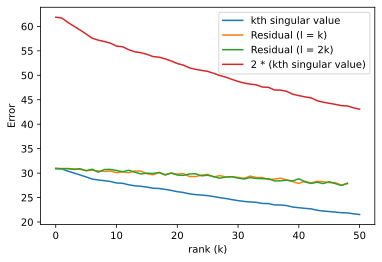

In [ ]:
plt.plot(A_s[:51], label='kth singular value')
plt.plot(residuals_lower_l, label='Residual (l = k)')
plt.plot(residuals_higher_l, label='Residual (l = 2k)')
plt.plot(2 * A_s[:51], label='2 * (kth singular value)')
plt.xlabel('rank (k)')
plt.ylabel('Error')
plt.legend()
plt.savefig("error_k_plot.pdf")
plt.show()

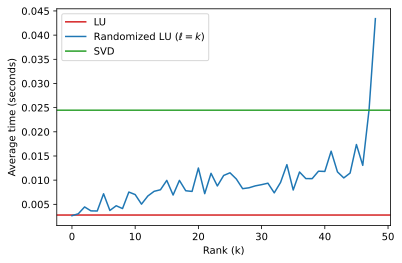

In [ ]:
plt.axhline(nonrandomized_time, label='LU', color='tab:red')
plt.plot(randomized_times, label='Randomized LU ($\ell = k$)')
plt.axhline(svd_time, label='SVD', color='tab:green')
plt.xlabel('Rank (k)')
plt.ylabel('Average time (seconds)')
plt.legend()
plt.savefig("time_rlu_plot.pdf")
plt.show()